In [40]:
!pip install numpy pandas matplotlib torch torchvision torchaudio


[notice] A new release of pip is available: 23.1.2 -> 23.3
[notice] To update, run: python.exe -m pip install --upgrade pip


### Load Dataset

In [41]:
from torch.utils.data import DataLoader
from torchvision import datasets, transforms

train_dataset = datasets.MNIST(
    root="./mnist", train=True, transform=transforms.ToTensor(), download=True
)

test_dataset = datasets.MNIST(
    root="./mnist", train=False, transform=transforms.ToTensor()
)

In [42]:
import torch
from torch.utils.data.dataset import random_split

torch.manual_seed(1)
train_dataset, val_dataset = random_split(train_dataset, lengths=[55000, 5000])


In [43]:
train_loader = DataLoader(
    dataset=train_dataset,
    batch_size=64,
    shuffle=True,
)

val_loader = DataLoader(
    dataset=val_dataset,
    batch_size=64,
    shuffle=False,
)

test_loader = DataLoader(
    dataset=test_dataset,
    batch_size=64,
    shuffle=False,
)

In [44]:
from collections import Counter

train_counter = Counter()
for images, labels in train_loader:
    train_counter.update(labels.tolist())

print(f"\nTraining label distribution:\n{sorted(train_counter.items())}")


val_counter = Counter()
for images, labels in val_loader:
    val_counter.update(labels.tolist())

print(f"\nValidation label distribution:\n{sorted(val_counter.items())}")


test_counter = Counter()
for images, labels in test_loader:
    test_counter.update(labels.tolist())

print(f"\nTest label distribution:\n{sorted(test_counter.items())}")


Training label distribution:
[(0, 5419), (1, 6185), (2, 5477), (3, 5681), (4, 5349), (5, 4974), (6, 5422), (7, 5710), (8, 5351), (9, 5432)]

Validation label distribution:
[(0, 504), (1, 557), (2, 481), (3, 450), (4, 493), (5, 447), (6, 496), (7, 555), (8, 500), (9, 517)]

Test label distribution:
[(0, 980), (1, 1135), (2, 1032), (3, 1010), (4, 982), (5, 892), (6, 958), (7, 1028), (8, 974), (9, 1009)]


### Zero-rule classifier / majority class classifier

In [45]:
majority_class = test_counter.most_common(1)[0]
print(f"Majority class {majority_class[0]}")

baseline_acc = majority_class[1] / sum(test_counter.values())
print(f"Accuracy when always predicting majority class {baseline_acc:.2f} {baseline_acc * 100:.2f}%")

Majority class 1
Accuracy when always predicting majority class 0.11 11.35%


### Visualize data

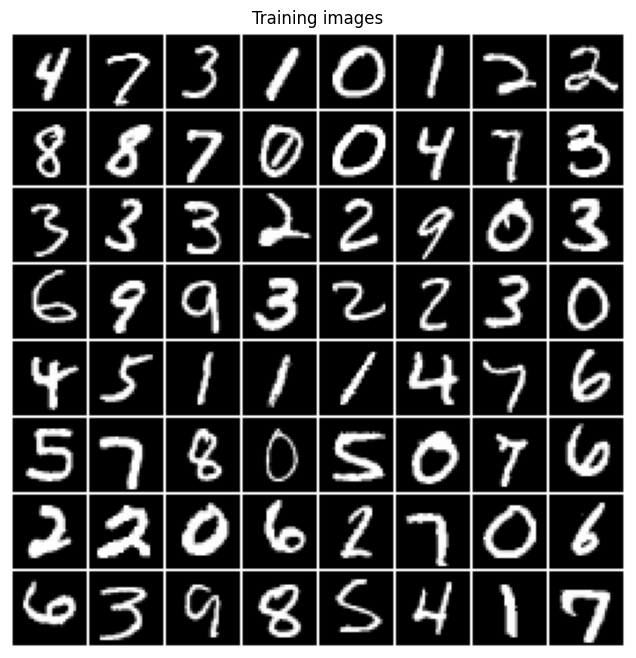

In [46]:
import matplotlib.pyplot as plt
import numpy as np
import torchvision

for images, labels in train_loader:
    break

plt.figure(figsize=(8, 8))
plt.axis("off")
plt.title("Training images")
plt.imshow(
    np.transpose(torchvision.utils.make_grid(
        images[:64],
        padding=1, pad_value=1.0,
        normalize=True),
        (1, 2, 0)
    ))
plt.show()

### Implement the model

In [47]:
images.shape  # batchsize, channel, height, width

torch.Size([64, 1, 28, 28])

In [48]:
torch.flatten(images, start_dim=1).shape

torch.Size([64, 784])

In [49]:
class PyTorchMLP(torch.nn.Module):

    def __init__(self, num_features, num_classes):
        super().__init__()

        self.all_layers = torch.nn.Sequential(

            # first hidden layer
            torch.nn.Linear(num_features, 100),
            torch.nn.ReLU(),

            # # second hidden layer
            # torch.nn.Linear(50, 25),
            # torch.nn.ReLU(),

            # output layer
            torch.nn.Linear(100, num_classes),
        )


    def forward(self, x):
        x = torch.flatten(x, start_dim=1)
        logits = self.all_layers(x)
        return logits

### Training Model

In [50]:
def compute_accuracy(model, dataloader):

    model = model.eval()

    correct = 0.0
    total_examples = 0

    for idx, (features, labels) in enumerate(dataloader):

        with torch.inference_mode():
            logits = model(features)

        predictions = torch.argmax(logits, dim=1)


        compare = labels == predictions
        correct += torch.sum(compare)
        total_examples += len(compare)

    return correct / total_examples

In [51]:
import torch.nn.functional as F

torch.manual_seed(1)

model = PyTorchMLP(num_features=784, num_classes=10)
optimizer = torch.optim.SGD(model.parameters(), lr=0.05)
num_epochs = 10

for epoch in range(num_epochs):
    model = model.train()

    for batch_idx, (features, labels) in enumerate(train_loader):

        logits = model(features)
        loss = F.cross_entropy(logits, labels)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        if not batch_idx % 250:
            print(f"Epoch: {epoch + 1:03d} / {num_epochs:03d}"
                  f" | Batch {batch_idx:03d} / {len(train_loader):03d}"
                  f" | Train/Val loss: {loss:2f}")

    train_acc = compute_accuracy(model, train_loader)
    val_acc = compute_accuracy(model, val_loader)
    print(f"Train accuracy: {train_acc} | Val accuracy: {val_acc}")

Epoch: 010 / 010 | Batch 500 / 860 | Train/Val loss: 0.097949
Epoch: 010 / 010 | Batch 750 / 860 | Train/Val loss: 0.096911
Train accuracy: 0.9705818295478821 | Val accuracy: 0.9598000049591064
Epoch: 001 / 010 | Batch 000 / 860 | Train/Val loss: 2.302491
Epoch: 001 / 010 | Batch 250 / 860 | Train/Val loss: 0.529043
Epoch: 001 / 010 | Batch 500 / 860 | Train/Val loss: 0.333256
Epoch: 001 / 010 | Batch 750 / 860 | Train/Val loss: 0.379478
Train accuracy: 0.9064363837242126 | Val accuracy: 0.9093999862670898
Epoch: 002 / 010 | Batch 000 / 860 | Train/Val loss: 0.368783
Epoch: 002 / 010 | Batch 250 / 860 | Train/Val loss: 0.266353
Epoch: 002 / 010 | Batch 500 / 860 | Train/Val loss: 0.177921
Epoch: 002 / 010 | Batch 750 / 860 | Train/Val loss: 0.129161
Train accuracy: 0.9244727492332458 | Val accuracy: 0.9225999712944031
Epoch: 003 / 010 | Batch 000 / 860 | Train/Val loss: 0.306129
Epoch: 003 / 010 | Batch 250 / 860 | Train/Val loss: 0.339911
Epoch: 003 / 010 | Batch 500 / 860 | Train/Val

### Results evaluation

In [52]:
train_acc = compute_accuracy(model, train_loader)
val_acc = compute_accuracy(model, val_loader)
test_acc = compute_accuracy(model, test_loader)

print(f"Train accuracy: {train_acc * 100:.2f}%")
print(f"Validation accuracy: {val_acc * 100:.2f}%")
print(f"Test accuracy: {test_acc * 100:.2f}%")

Train accuracy: 97.06%
Validation accuracy: 95.98%
Test accuracy: 96.46%
Train accuracy: 97.06%
Validation accuracy: 95.98%
Test accuracy: 96.46%
